<a href="https://colab.research.google.com/github/plaisier-lab/python3_courses/blob/main/ecg_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Electrocardiogram (ECG) analysis using wfdb</h1>
<p>The <a href='https://en.wikipedia.org/wiki/Heart'>heart</a> is the organ at the center of the circulatory system. It functions to send deoxygenated blood to the lungs and then distribute oxygenated blood coming from the lungs to all body parts. The heart is made up of both muscles to pump the blood, valves to regulate flow, and an electrical system to synchronize the beating of atrial and ventricles.</p>

<center><img src='https://media.tenor.com/Xx2YeqghQtkAAAAC/heartbeat-conduction.gif' width='200'></center>
<p><b>Figure 1</b>. The physiology of a heartbeat. Blood is shown as a dark fluid that fills the ventricles and is pumped out. The electrical signaling is shown as it starts in the sinoatrial node, the atria, and finally in the ventricle.</p>

<p>The electrical signal generated by the heart can be detected by putting voltage sensing electrodes on the body in specific postions.
<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Limb_leads_of_EKG.png/600px-Limb_leads_of_EKG.png'></center></p>

<p>The readouts are called an electrocardiogram or ECG are sampled at a specific rate (samples/sec or Hertz), and over an interval of time which leads to a set of samples. A typical heart beat is made up of three components:  "the P wave, which represents depolarization of the atria; the QRS complex, which represents depolarization of the ventricles; and the T wave, which represents repolarization of the ventricles." - <a href='https://en.wikipedia.org/wiki/Electrocardiography'>Wikipedia</a>
<center><img src='https://ecgwaves.com/wp-content/uploads/2018/01/ekg-ecg-interpretation-p-qrs-st-t-wave.jpg'></center></p>

<h2><a href='https://physionet.org'>Physionet.org</a></h2>
<p>A cooperative project with a mission to advance biomedical research and education. It has very useful signals including ECGs that we can download to test out tools and learn. The PhysioBank is an extensive archive of recorded biomedical signals (e.g., cardiopulmonary and neural signals), the PhysioToolkit is a library of software for physiologic signal processing and analysis (including wfdb), and offers educational materials.</p>

<h3>Waveform Database Python package wfdb</h3>
<p>Physionet offers a tool called Waveform Database or wfdb which is a Python package that can interface with Physionet data. It can Read/Write physiological signal files and associated annotations, plot the signals and annotations, process the signal, perform analysis (e.g. extract features of interest).</p>
<ul>
    <li>Install using:  pip install wfdb</li>
    <li><a href='https://wfdb.readthedocs.io/en/latest/'>wfdb Application programming interface (API)</a></li>
</ul>

In [2]:
# Installing wfdb
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 6.6 MB/s 


<h2>Goal for analyses</h2>
<ol>
    <li>Load ECG data</li>
    <li>Plot data and choose a channel to process</li>
    <li>Detect QRS complex</li>
    <li>Determine R-R intervals</li>
    <li>Statistics of R-R intervals</li>
</ol>

<h2>Data for analyses</hd>
<p>"This database includes 18 long-term ECG recordings of subjects referred to the Arrhythmia Laboratory at Boston's Beth Israel Hospital (now the Beth Israel Deaconess Medical Center). Subjects included in this database were found to have had no significant arrhythmias; they include 5 men, aged 26 to 45, and 13 women, aged 20 to 50." - <a href='https://physionet.org/content/nsrdb/1.0.0/'>Physionet.org</a></p>

In [15]:
## Import packages for analyses
import wfdb
from wfdb import processing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os

<h2>1. Load ECG data</h2>
<h3>1.1 Dowload data from Physionet.org</h3>

<p>We will only work with ECG traces from two individuals 16265 and 16273. We will use the wget command line program to download the .atr, .dat, .hea, and .xws files.</p>

In [4]:
#!wget https://physionet.org/static/published-projects/nsrdb/mit-bih-normal-sinus-rhythm-database-1.0.0.zip
#!unzip mit-bih-normal-sinus-rhythm-database-1.0.0.zip
!wget -O 16265.atr https://physionet.org/files/nsrdb/1.0.0/16265.atr?download
!wget -O 16265.dat https://physionet.org/files/nsrdb/1.0.0/16265.dat?download
!wget -O 16265.hea https://physionet.org/files/nsrdb/1.0.0/16265.hea?download
!wget -O 16265.xws https://physionet.org/files/nsrdb/1.0.0/16265.xws?download
!wget -O 16273.atr https://physionet.org/files/nsrdb/1.0.0/16273.atr?download
!wget -O 16273.dat https://physionet.org/files/nsrdb/1.0.0/16273.dat?download
!wget -O 16273.hea https://physionet.org/files/nsrdb/1.0.0/16273.hea?download
!wget -O 16273.xws https://physionet.org/files/nsrdb/1.0.0/16273.xws?download

--2022-11-18 22:44:55--  https://physionet.org/files/nsrdb/1.0.0/16265.atr?download
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304326 (297K) [application/octet-stream]
Saving to: ‘16265.atr’

16265.atr           100%[===================>] 297.19K  1.22MB/s    in 0.2s    

2022-11-18 22:44:56 (1.22 MB/s) - ‘16265.atr’ saved [304326/304326]

--2022-11-18 22:44:56--  https://physionet.org/files/nsrdb/1.0.0/16265.dat?download
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35192832 (34M) [application/octet-stream]
Saving to: ‘16265.dat’

16265.dat           100%[===================>]  33.56M  3.06MB/s    in 11s     

2022-11-18 22:45:08 (3.03 MB/s) - ‘16265.dat’ saved [35192832/35192832]

--2022-11-18 22:45:08--  ht

<h3>1.2 Load data files using wfdb</h3>

<h4>1.2.1 Set up paths</h4>
<p>Next, the goal is to load up ECG traces from the two individuals. But first we need to set our directory structure and make sure the files are located where we expect:</p>

In [5]:
## Step 2: Store the ECG folder's name
ecgfolder_name = "/content"

In [6]:
## Step 3: Check if the ECG folder is in the current working directory
path = os.getcwd() #returns the absolute path of the current working directory
print(os.listdir(path))

['.config', '16273.atr', '16273.xws', '16265.atr', '16273.dat', '16273.hea', '16265.xws', '16265.hea', '16265.dat', 'sample_data']


<h4>1.2.2 Subsetting data</h4>
<p>The traces are very long, therefore we will select only the first 10 minutes. Given that the sampling rate was 128 Hertz (samples per second), we want to have:</p>


```
10 minutes * 60 seconds/minute * 128 samples/second = 76800 samples
```

<h4>1.2.3 Load data</h4>
<p>We will use the <a href='https://wfdb.readthedocs.io/en/latest/io.html#wfdb.io.rdsamp'>wfdb.io.readsamp</a> as the method to read in the ECG traces and their meta-information (information about the patient, sampling rate, etc.).</p>

<p>A standard wfdb.io.readsamp looks like this:</p>


```
<var_to_store_ECG> = wfdb.io.rdsamp(record_name = '<path_to_files>', sampfrom = 0, sampto = 76800)
```

<ul>
    <li><b>record_name</b> = The name of the WFDB record to be read (without any file extensions). If the argument contains any path delimiter characters, the argument will be interpreted as PATH/baserecord and the data files will be searched for in the local path.</li>
    <li><b>sampfrom</b> = <i>(optional)</i> The starting sample number to read for all channels.</li>
    <li><b>sampto</b> = <i>(optional)</i> The sample number at which to stop reading for all channels. Reads the entire duration by default.</li>
</ul>
<p>
Note that if the sampfrom or sampto attributes are not included the full ECG trace will be loaded, which is the default approach.
</p>
<h4>1.2.4 Save data</h4>
<p>Each ECG trace is being saved into a list ECGs and the name of the files is also being stored in ecgfile_names.</p>

In [7]:
## Step 4: Read ECG data from all subjects by iterating over the list of .dat files
ECGs = []
ecgfile_names = []
for name in sorted(os.listdir(ecgfolder_name)):
    if name.endswith(".dat"):
        ecg = wfdb.io.rdsamp(ecgfolder_name + '/' + name.split(".")[0], sampfrom = 0, sampto =76800) # 10 min * 60 sec/min * 128 samps/sec
        ECGs.append(ecg)
        ecgfile_names.append(name.split(".")[0])

<h5>1.2.5 Explore data</h5>
<p>Each ECG trace can be accessed through it's index (e.g., 0, 1, ..., len(ECGs)-1). Each ECG trace is a tuple with two elements. The first '[0]' element is the ECG trace with two values time and mV. The second '[1]' element is the meta-data from the trace with:</p>
<ul>
    <li><b>fs</b> - sampling frequency in Hertz</li>
    <li><b>sig_len</b> - numer of samples</li>
    <li><b>n_sig</b> - number of signals</li>
    <li><b>base_data</b> - date when sampling was done</li>
    <li><b>base_time</b> - time when sampling was done</li>
    <li><b>units</b> - units of each signal</li>
    <li><b>sig_name</b> - name of each signal</li>
    <li><b>comments</b> - extra meta-information that doesn't fit into these other categories</li> 
</ul>

In [8]:
print(ECGs[0][1])
print((ECGs[0][1]['sig_len']/ECGs[0][1]['fs'])/60)

{'fs': 128, 'sig_len': 76800, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(8, 4), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': ['32 M']}
10.0


<h2>2. Plot data and choose a channel to process<h2>
<p>The different leads in an ECG capture different aspects of the heart electrophysiology. For processing we are looking for a signal that best represnts a standard heartbeat:</p>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/3/34/EKG_Complex_en.svg'></center>
<p>For each individual we have two signals ECG1 and ECG2 that we could potentially process. We will plot the signals to figure out which signal looks most like the signal above.</p>

<h4>2.1 Plot ECG signals</h4>
<p>A standard call of wfdb.plot.plot_items looks like this:</p>


```
fig1,axes1 = wfdb.plot.plot_items(signal = <ECG_signal>, fs = <fs>, time_units = 'seconds', sig_nam = <sig_name>, sig_units = <sig_units>, title = <title>, ecg_grids = 'all', figsize = (10,20), return_fig_axes = True)
plt.show()
```

<ul>
    <li><b>signal</b> = signal from each channel.</li>
    <li><b>fs</b> = sampling frequency.</li>
    <li><b>sig_name</b> = name of signals.</li>
    <li><b>sig_units</b> = units of signals.</li>
    <li><b>title</b> = title of plot.</li>
    <li><b>ecg_grids</b> = which signals to plot.</li>
    <li><b>figsize</b> = size of the figure.</li>
    <li><b>return_fig_axes</b> = whether to return the figure axes.</li>
</ul>

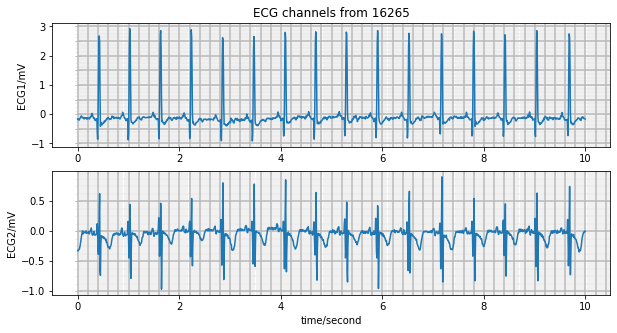

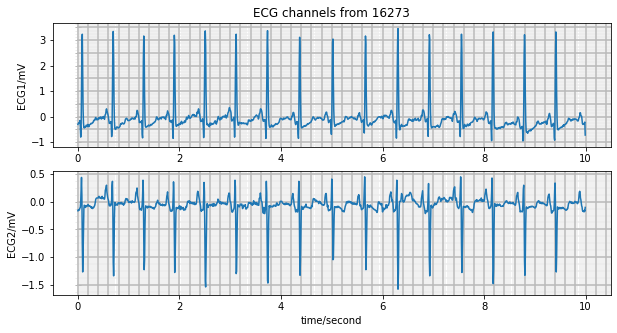

In [18]:
for idx in range(len(ECGs)):
    fig1,axes1  = wfdb.plot.plot_items(signal=ECGs[idx][0][0:1280,:], fs=ECGs[idx][1]['fs'], 
                                   time_units='seconds', sig_name=ECGs[idx][1]['sig_name'],
                                   sig_units=ECGs[idx][1]['units'], title='ECG channels from '+ecgfile_names[idx],
                                   ecg_grids='all', figsize=(10,5),return_fig_axes=True)
    plt.show()

<h4>2.2 Choose signal channel for processing</h4>
<p>Based on these ECG plots we see that ECG1 is the best match to the normal ECG signal. So we can choos that as the channel to process by setting the variable ch_idx.</p>

In [10]:
ch_idx = 0 # index of the ECG channel of interest in the ECG . dat file

<h2>3. Detect QRS complex</h2>
<p>Next we will detect each heartbeat by identifying its central peak change in voltage the QRS complex.</p>
<center><img src='https://upload.wikimedia.org/wikipedia/commons/3/34/EKG_Complex_en.svg'></center>
<h4>3.1 A QRS complex detector</h4>
<p>The QRS detector class for the XQRS algorithm. The XQRS.Conf class is the configuration class that stores initial parameters for the detection. The XQRS.detect method runs the detection algorithm.

The process works as follows:</p>

<ul>
    <li>Load the signal and configuration parameters.</li>
    <li>Bandpass filter the signal between 5 and 20 Hz, to get the filtered signal.</li>
    <li>Apply moving wave integration (MWI) with a Ricker (Mexican hat) wavelet onto the filtered signal, and save the square of the integrated signal.</li>
    <li>Conduct learning if specified, to initialize running parameters of noise and QRS amplitudes, the QRS detection threshold, and recent R-R intervals. If learning is unspecified or fails, use default parameters. See the docstring for the _learn_init_params method of this class for details.</li>
    <li>Run the main detection. Iterate through the local maxima of the MWI signal. For each local maxima:</li>
    <ul>
        <li>Check if it is a QRS complex. To be classified as a QRS, it must come after the refractory period, cross the QRS detection threshold, and not be classified as a T-wave if it comes close enough to the previous QRS. If successfully classified, update running detection threshold and heart rate parameters.</li>
        <li>If not a QRS, classify it as a noise peak and update running parameters.</li>
        <li>Before continuing to the next local maxima, if no QRS was detected within 1.66 times the recent R-R interval, perform backsearch QRS detection. This checks previous peaks using a lower QRS detection threshold.</li>
    </ul>
</ul>

<h4>3.2 Running the QRS detector</h4>
<p>The method used from wfdb is wfdb.processing.XQRS and is parameterized as follows:</p>

```
xqrs = processing.XQRS(sig=<ECG_signal_1_channel>, fs=<sampling_frequency>)
xqrs.detect()
```

<ul>
    <li><b>signal</b> = signal from one channel.</li>
    <li><b>fs</b> = sampling frequency.</li>
</ul>

In [24]:
xqrss = []
for idx in range(len(ECGs)):
    xqrs = processing.XQRS(sig=ECGs[idx][0][:,ch_idx], fs=ECGs[idx][1]['fs'])
    xqrs.detect()
    xqrss.append(xqrs)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


<h4>3.3 Plot QRS complex locations</h4>
<p>An annotated call of wfdb.plot.plot_items looks like this:</p>


```
fig1,axes1 = wfdb.plot.plot_items(signal = <ECG_signal>, ann_samp=<annotations>, fs = <fs>, time_units = 'seconds', sig_nam = <sig_name>, sig_units = <sig_units>, title = <title>, ecg_grids = 'all', figsize = (10,20), return_fig_axes = True)
plt.show()
```

<ul>
    <b>New:</b>
    <li><b>ann_samp</b> = annotations to add to the plot. In this case the location of the QRS peaks stored in the XQRS output.</li></br>
    <b>Same as before:</b>
    <li><b>signal</b> = signal from each channel.</li>
    <li><b>fs</b> = sampling frequency.</li>
    <li><b>sig_name</b> = name of signals.</li>
    <li><b>sig_units</b> = units of signals.</li>
    <li><b>title</b> = title of plot.</li>
    <li><b>ecg_grids</b> = which signals to plot.</li>
    <li><b>figsize</b> = size of the figure.</li>
    <li><b>return_fig_axes</b> = whether to return the figure axes.</li>
</ul>

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


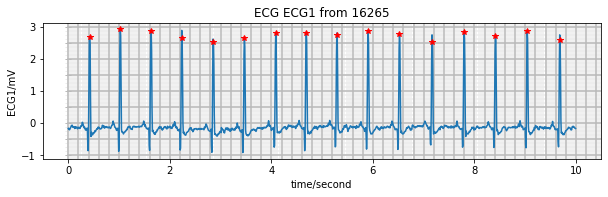

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


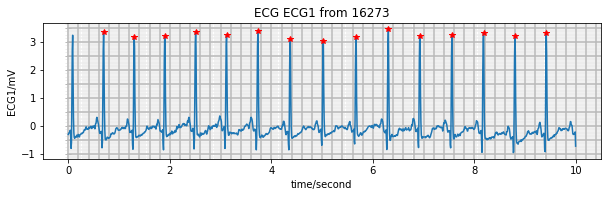

In [27]:
for idx in range(len(ECGs)):
    # Need to rerun XQRS for just the first 10 seconds
    xqrs = processing.XQRS(sig=ECGs[idx][0][0:1280,ch_idx], fs=ECGs[idx][1]['fs'])
    xqrs.detect()
    # Next plot the ECG data with annotated QRS
    wfdb.plot.plot_items(signal=ECGs[idx][0][0:1280,ch_idx], ann_samp=[xqrs.qrs_inds],fs=ECGs[idx][1]['fs'], 
                         time_units='seconds', sig_name=[ECGs[idx][1]['sig_name'][ch_idx]],
                         sig_units=[ECGs[idx][1]['units'][ch_idx]], title='ECG '+ ECGs[idx][1]['sig_name'][ch_idx]+' from '+ecgfile_names[idx],
                         ecg_grids= [0], figsize=(10,2.5),return_fig_axes=True) 
    plt.show()

The stars indicate the locations of the QRS complex peaks. From looking at the data we can see they line up nicely with the data, and so we can be happy that the inference is working as expected. Doing spot chekcing of your analysis is very helpful to ensure that everything is working as you want.

<h2>4. Determine R-R intervals</h2>
<p>The R-R interval is the time that elapses between the peak of ventricular contraction between two heartbeats. The time interval between heartbeats has a normal amount of fluctuation (variance).</p>

<center><img src='https://assets.firstbeat.com/firstbeat/uploads/2018/04/heart-rate-variability-firstbeat.jpg'></center>

<h4>4.1 Computer R-R intervals</h4>
<p>Once the QRS peaks have been defined as above in section 3.6 we can compute the interval between adjacent peaks, which is the R-R interval.</p>

<p></p>



In [28]:
# Computer R-R intervals
rrs = []
for idx in range(len(ECGs)):
    rrs.append(wfdb.processing.calc_rr(xqrss[idx].qrs_inds, fs=ECGs[idx][1]['fs'], min_rr=None, max_rr=None, qrs_units='samples', rr_units='samples'))

<h4>4.2 Plot distribution of R-R intervals</h4>

<p>The distribution of R-R intervals can be helpful in determing the health of a persons heart. One way to observe this distribution is to plot it using a histogram. The R-R interval is given as samples not miliseconds. So we need to convert it by dividing by the sampling frequency and multiplying by the sampling frequency.</p>

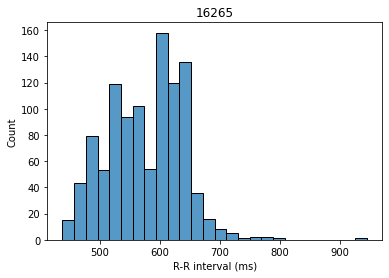

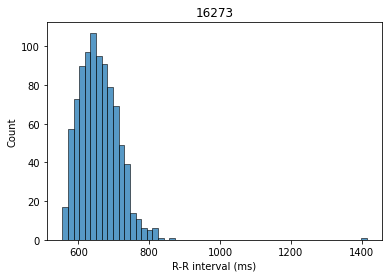

In [33]:
# Make histograms of R-R intervals
for idx in range(len(ECGs)):
    ax = sns.histplot((rrs[idx]/ECGs[idx][1]['fs'])*1000)
    ax.set(xlabel='R-R interval (ms)', title=ecgfile_names[idx])
    plt.show()

<h2>5. Statistics of R-R intervals</h2>

<h4>5.1 Mean R-R interval</h4>

<p>The R-R intervals are stored in a np.array which makes calculating statistics very easy. The mean of the R-R interval can be computed using the np.array.mean() method, and likewise the standard deviatio can be comptues using the np.array.std() method.</p>

In [41]:
rrs_means = []
rrs_stds = []
for idx in range(len(ECGs)):
    rrs_means.append(((rrs[idx]/ECGs[idx][1]['fs'])*1000).mean())
    rrs_stds.append(((rrs[idx]/ECGs[idx][1]['fs'])*1000).std())

print(rrs_means)
print(rrs_stds)

[573.7290669856459, 659.9841685022027]
[62.98645565436921, 57.4184388109279]


<h4>5.2 Finding arrhythmias</h4>
<p>Arrhythmias are irregularities in the time or shape of a heartbeat. These irregularities can cause the R-R interval to vary beyond the normal range (premature atrial beat):</p>

<center><img src='https://www.medicomholter.ru/storage/app/media/medicom_research_lab/afib_detector/Fig_1.png'></center>

<p>We can detect arrhythmias as deviations from the normal R-R interval range. Statistically, this can be represented as the observed R-R interval outside of an interval surrounding the mean value. For these analyses, please use the mean R-R interval +/- 2 times the standard deviation of the R-R interval.

$$
\mu\pm(2*\sigma)
$$

What you will be looking for is if the values are either:
<ul>
    <li>$$ rr_{interval_{high}} \ge  \mu + (2 * \sigma) $$
    <li>$$ rr_{interval_{low}} \le \mu - (2 * \sigma) $$
</ul>
</p>

In [42]:
lows = []
highs = []
for idx in range(len(ECGs)):
    lows.append(sum(((rrs[idx]/ECGs[idx][1]['fs'])*1000)<=(rrs_means[idx]-(2*rrs_stds[idx]))))
    highs.append(sum(((rrs[idx]/ECGs[idx][1]['fs'])*1000)>=(rrs_means[idx]+(2*rrs_stds[idx]))))

print(lows)
print(highs)

[12, 0]
[15, 20]


<p>The statistsics mean and std helped us to identify some small number of R-R intervals that fall outside of our 2&sigma; cutoff. We would expect to see at least 2.1% of our data points in this range.</p> 

In [46]:
print((lows[0]/len(rrs[0]))*100)
print((lows[1]/len(rrs[1]))*100)
print((highs[0]/len(rrs[0]))*100)
print((highs[1]/len(rrs[1]))*100)

1.1483253588516746
0.0
1.4354066985645932
2.2026431718061676


Which is what we find. So our there normal samples fall well within our expected range of values outside the 2&sigma; interval. So no arrhythmia is observed in this case.